# Hoja de Trabajo 2 Deep Learning

Hoja de trabajo 2 – Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119

Link del repositorio:<br>
https://github.com/EstebanZG999/HDT2_DL

## Ejercicio 1 - Experimentación Práctica

### Task 1 Preparación del conjunto de datos

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar dataset
iris = load_iris()
X, y = iris.data, iris.target

# Normalizar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)


Train shape: torch.Size([120, 4]) torch.Size([120])
Validation shape: torch.Size([30, 4]) torch.Size([30])


### Task 2 Arquitectura modelo

In [8]:
import torch
import torch.nn as nn

def get_activation(name: str) -> nn.Module:
    """Devuelve una activación por nombre."""
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    if name == "leakyrelu":
        return nn.LeakyReLU()
    if name == "gelu":
        return nn.GELU()
    raise ValueError(f"Activación no soportada: {name}")

class MLPClassifier(nn.Module):
    """
    MLP simple para clasificación en Iris:
    - Arquitectura parametrizable: hidden_layers, activación, dropout.
    - Última capa produce logits (sin softmax); compat. con CrossEntropyLoss.
    """
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_layers=(16, 16),
        activation="relu",
        dropout_p=0.0,
        use_batchnorm=False,
    ):
        super().__init__()
        act = get_activation(activation)

        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(act)
            if dropout_p and dropout_p > 0:
                layers.append(nn.Dropout(p=dropout_p))
            prev = h

        # Capa de salida (logits)
        layers.append(nn.Linear(prev, output_dim))

        self.net = nn.Sequential(*layers)

        # Inicialización razonable (Kaiming para ReLU/LeakyReLU, Xavier para otras)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if activation.lower() in ["relu", "leakyrelu"]:
                    nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                else:
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# Instancia recomendada para Iris
input_dim = 4   # iris.features
output_dim = 3  # 3 clases
model = MLPClassifier(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_layers=(32, 16),   
    activation="relu",        # "relu", "tanh", "gelu", "leakyrelu"
    dropout_p=0.0,
    use_batchnorm=False
)

print(model)
sum_params = sum(p.numel() for p in model.parameters())
print(f"Parámetros totales: {sum_params}")


MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)
Parámetros totales: 739


### Task 3 Funciones de Pérdida

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy
import math
import random

# --- Utilidades reproducibilidad ---
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# --- DataLoaders ---
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

# --- Mapeo de pérdidas y transformaciones necesarias ---
class LossAdapter:
    """
    Adapta salida (logits) y targets para cada pérdida:
    - crossentropy: usa logits y targets long (clase)
    - mse: usa softmax(logits) vs one-hot (float)
    - kldiv: usa log_softmax(logits) vs one-hot (float)
    """
    def __init__(self, loss_name: str, num_classes: int):
        self.loss_name = loss_name.lower()
        self.num_classes = num_classes

        if self.loss_name == "crossentropy":
            self.criterion = nn.CrossEntropyLoss()
        elif self.loss_name == "mse":
            self.criterion = nn.MSELoss()
        elif self.loss_name in ("kldiv", "kl", "kl_div"):
            self.criterion = nn.KLDivLoss(reduction="batchmean")
        else:
            raise ValueError(f"Pérdida no soportada: {loss_name}")

    def prepare(self, logits, targets):
        """
        Devuelve (preds_para_loss, targets_para_loss) según la pérdida.
        """
        if self.loss_name == "crossentropy":
            # logits (N,C), targets long (N,)
            return logits, targets

        elif self.loss_name == "mse":
            probs = F.softmax(logits, dim=1)             
            onehot = F.one_hot(targets, self.num_classes).float() 
            return probs, onehot

        elif self.loss_name in ("kldiv", "kl", "kl_div"):
            log_probs = F.log_softmax(logits, dim=1)   
            onehot = F.one_hot(targets, self.num_classes).float()
            return log_probs, onehot

    def __call__(self, logits, targets):
        a, b = self.prepare(logits, targets)
        return self.criterion(a, b)

# --- Métrica de accuracy estándar ---
@torch.no_grad()
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

# --- Ciclos de entrenamiento y evaluación ---
def train_one_epoch(model, loader, optimizer, loss_adapter, device="cpu"):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_adapter(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        running_loss += loss.item() * bs
        running_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, loss_adapter, device="cpu"):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_adapter(logits, yb)
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, yb) * bs
        n += bs
    return total_loss / n, total_acc / n

# --- Entrenamiento para un experimento con una pérdida dada ---
def fit_with_loss(
    base_model,
    loss_name="crossentropy",
    lr=1e-2,
    epochs=100,
    device="cpu"
):
    model = deepcopy(base_model).to(device)
    loss_adapter = LossAdapter(loss_name, num_classes=3)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_adapter, device)
        va_loss, va_acc = evaluate(model, val_loader, loss_adapter, device)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        if ep % 20 == 0 or ep == 1:
            print(f"[{loss_name:>11}] Epoch {ep:3d} | "
                  f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} | "
                  f"train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")

    final = {
        "loss": loss_name,
        "train_loss": history["train_loss"][-1],
        "val_loss": history["val_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_acc": history["val_acc"][-1],
        "history": history,
        "model": model, 
    }
    return final

# --- Ejecutar los tres experimentos solicitados ---
losses_to_try = ["crossentropy", "mse", "kldiv"]  # CE + MSE + KLDiv (3 pérdidas)
results = []
for lname in losses_to_try:
    res = fit_with_loss(model, loss_name=lname, lr=1e-2, epochs=120, device="cpu")
    results.append(res)

# --- Resumen ---
print("\n=== Resumen Task 3 ===")
for r in results:
    print(f"{r['loss']:>11} -> "
          f"train_loss={r['train_loss']:.4f} | val_loss={r['val_loss']:.4f} | "
          f"train_acc={r['train_acc']:.3f} | val_acc={r['val_acc']:.3f}")


[crossentropy] Epoch   1 | train_loss=1.0645 val_loss=0.6161 | train_acc=0.417 val_acc=0.667
[crossentropy] Epoch  20 | train_loss=0.0862 val_loss=0.1873 | train_acc=0.975 val_acc=0.933
[crossentropy] Epoch  40 | train_loss=0.0449 val_loss=0.1420 | train_acc=0.983 val_acc=0.933
[crossentropy] Epoch  60 | train_loss=0.0415 val_loss=0.1318 | train_acc=0.983 val_acc=0.967
[crossentropy] Epoch  80 | train_loss=0.0227 val_loss=0.1265 | train_acc=0.992 val_acc=0.933
[crossentropy] Epoch 100 | train_loss=0.0181 val_loss=0.1280 | train_acc=1.000 val_acc=0.933
[crossentropy] Epoch 120 | train_loss=0.0146 val_loss=0.1275 | train_acc=1.000 val_acc=0.967
[        mse] Epoch   1 | train_loss=0.3094 val_loss=0.2233 | train_acc=0.192 val_acc=0.400
[        mse] Epoch  20 | train_loss=0.0406 val_loss=0.0620 | train_acc=0.958 val_acc=0.900
[        mse] Epoch  40 | train_loss=0.0247 val_loss=0.0472 | train_acc=0.967 val_acc=0.900
[        mse] Epoch  60 | train_loss=0.0170 val_loss=0.0402 | train_acc=0

### Task 4

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

# --- Helper: penalización L1 (por nombre, solo pesos .weight) ---
def l1_penalty(model, lambda_l1=0.0):
    if lambda_l1 <= 0: 
        return torch.tensor(0.0, device=next(model.parameters()).device)
    l1 = 0.0
    for name, p in model.named_parameters():
        if ("weight" in name) and p.requires_grad:
            l1 = l1 + p.abs().sum()
    return lambda_l1 * l1

# --- Versión extendida del loop para incluir L1 y L2 (weight_decay) ---
def fit_with_reg(
    base_model,
    loss_name="crossentropy",
    lr=1e-2,
    epochs=120,
    device="cpu",
    # Regularización:
    weight_decay=0.0,         # L2 en el optimizador 
    lambda_l1=0.0,            # L1 manual
    dropout_p=0.0,            # Dropout en arquitectura
    use_batchnorm=False,
    batch_size=16,
):

    input_dim = 4
    output_dim = 3
    # Puedes ajustar hidden_layers para mantenerlo constante en todas las pruebas
    arch = MLPClassifier(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_layers=(32, 16),
        activation="relu",
        dropout_p=dropout_p,
        use_batchnorm=use_batchnorm,
    ).to(device)

    # Reusar el adaptador de pérdidas 
    loss_adapter = LossAdapter(loss_name, num_classes=3)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val), batch_size=32, shuffle=False
    )

    # Optimizador con L2 (weight_decay)
    optimizer = torch.optim.SGD(arch.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs + 1):
        # ---- Train ----
        arch.train()
        tr_loss_sum, tr_acc_sum, n = 0.0, 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = arch(xb)
            loss_main = loss_adapter(logits, yb)
            loss = loss_main + l1_penalty(arch, lambda_l1=lambda_l1)  # agregar L1
            loss.backward()
            optimizer.step()

            bs = yb.size(0)
            tr_loss_sum += loss.item() * bs
            tr_acc_sum  += (logits.argmax(1) == yb).float().sum().item()
            n += bs
        tr_loss = tr_loss_sum / n
        tr_acc  = tr_acc_sum / n

        # ---- Val ----
        arch.eval()
        with torch.no_grad():
            va_loss_sum, va_acc_sum, m = 0.0, 0.0, 0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = arch(xb)
                va_loss = loss_adapter(logits, yb)
                bs = yb.size(0)
                va_loss_sum += va_loss.item() * bs
                va_acc_sum  += (logits.argmax(1) == yb).float().sum().item()
                m += bs
        va_loss = va_loss_sum / m
        va_acc  = va_acc_sum / m

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        if ep % 20 == 0 or ep == 1:
            print(f"[ep {ep:3d}] "
                  f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} | "
                  f"train_acc={tr_acc:.3f} val_acc={va_acc:.3f} | "
                  f"L2(wd)={weight_decay} L1={lambda_l1} drop={dropout_p} BN={use_batchnorm}")

    final = {
        "train_loss": history["train_loss"][-1],
        "val_loss": history["val_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_acc": history["val_acc"][-1],
        "history": history,
        "model": arch,
        "config": dict(loss=loss_name, lr=lr, epochs=epochs, weight_decay=weight_decay,
                       lambda_l1=lambda_l1, dropout_p=dropout_p, use_batchnorm=use_batchnorm,
                       batch_size=batch_size),
    }
    return final

# --- Experimentos mínimos requeridos ---
exps = [
    # Baseline sin regularización
    dict(loss_name="crossentropy", weight_decay=0.0, lambda_l1=0.0, dropout_p=0.0, use_batchnorm=False),

    # L2 (weight decay)
    dict(loss_name="crossentropy", weight_decay=1e-3, lambda_l1=0.0, dropout_p=0.0, use_batchnorm=False),

    # L1
    dict(loss_name="crossentropy", weight_decay=0.0, lambda_l1=1e-4, dropout_p=0.0, use_batchnorm=False),

    # Dropout
    dict(loss_name="crossentropy", weight_decay=0.0, lambda_l1=0.0, dropout_p=0.3, use_batchnorm=False),

    # combinar L2 + Dropout
    dict(loss_name="crossentropy", weight_decay=5e-4, lambda_l1=0.0, dropout_p=0.3, use_batchnorm=False),

    # BatchNorm
    dict(loss_name="crossentropy", weight_decay=0.0, lambda_l1=0.0, dropout_p=0.0, use_batchnorm=True),
]

reg_results = []
for cfg in exps:
    res = fit_with_reg(
        base_model=model,
        loss_name=cfg["loss_name"],
        lr=1e-2,
        epochs=120,
        device="cpu",
        weight_decay=cfg["weight_decay"],
        lambda_l1=cfg["lambda_l1"],
        dropout_p=cfg["dropout_p"],
        use_batchnorm=cfg["use_batchnorm"],
        batch_size=16,
    )
    reg_results.append(res)

print("\n=== Resumen Task 4 ===")
for r in reg_results:
    cfg = r["config"]
    print(f"L={cfg['loss']:<4} | L2(wd)={cfg['weight_decay']:<.1e} | L1={cfg['lambda_l1']:<.1e} "
          f"| drop={cfg['dropout_p']:.1f} | BN={cfg['use_batchnorm']} "
          f"-> train_acc={r['train_acc']:.3f} val_acc={r['val_acc']:.3f} "
          f"| train_loss={r['train_loss']:.4f} val_loss={r['val_loss']:.4f}")


[ep   1] train_loss=0.9869 val_loss=0.6518 | train_acc=0.608 val_acc=0.767 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep  20] train_loss=0.0779 val_loss=0.1232 | train_acc=0.983 val_acc=0.967 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep  40] train_loss=0.0421 val_loss=0.1040 | train_acc=0.992 val_acc=0.967 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep  60] train_loss=0.0249 val_loss=0.1102 | train_acc=0.992 val_acc=0.933 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep  80] train_loss=0.0189 val_loss=0.1129 | train_acc=1.000 val_acc=0.933 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep 100] train_loss=0.0127 val_loss=0.1062 | train_acc=1.000 val_acc=0.933 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep 120] train_loss=0.0100 val_loss=0.1111 | train_acc=1.000 val_acc=0.933 | L2(wd)=0.0 L1=0.0 drop=0.0 BN=False
[ep   1] train_loss=1.0180 val_loss=0.6631 | train_acc=0.417 val_acc=0.700 | L2(wd)=0.001 L1=0.0 drop=0.0 BN=False
[ep  20] train_loss=0.1076 val_loss=0.1337 | train_acc=0.967 val_acc=0.933 | L2(wd)=0.001 L1=0

### Task 5

In [11]:
import time
import torch
from copy import deepcopy

def make_loader(X, y, batch_size, shuffle):
    ds = torch.utils.data.TensorDataset(X, y)
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def create_optimizer(name, params, lr=1e-2, weight_decay=0.0, momentum=0.9):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    raise ValueError(f"Optimizador no soportado: {name}")

def fit_with_optimizer(
    optimizer_name="sgd",
    batch_mode="mini",          # "sgd" (bs=1), "mini" (p.ej. 16), "batch" (bs=N)
    lr=1e-2,
    epochs=120,
    device="cpu",
    batch_size_mini=16,
    weight_decay=0.0,
    momentum=0.9,
    loss_name="crossentropy",
    hidden_layers=(32, 16),
    dropout_p=0.0,
    use_batchnorm=False,
):
    # Re-instanciar modelo limpio por experimento
    model = MLPClassifier(
        input_dim=4, output_dim=3,
        hidden_layers=hidden_layers,
        activation="relu",
        dropout_p=dropout_p,
        use_batchnorm=use_batchnorm
    ).to(device)

    loss_adapter = LossAdapter(loss_name, num_classes=3)

    # Configurar batch size según modo
    if batch_mode == "sgd":
        bs = 1
    elif batch_mode == "mini":
        bs = batch_size_mini
    elif batch_mode == "batch":
        bs = len(X_train)
    else:
        raise ValueError(f"batch_mode desconocido: {batch_mode}")

    train_loader = make_loader(X_train, y_train, batch_size=bs, shuffle=True)
    val_loader   = make_loader(X_val,   y_val,   batch_size=len(X_val), shuffle=False)

    opt = create_optimizer(optimizer_name, model.parameters(), lr=lr,
                           weight_decay=weight_decay, momentum=momentum)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "epoch_train_time": [], "epoch_val_time": []
    }

    t0_total = time.perf_counter()
    for ep in range(1, epochs+1):
        # ---- Train ----
        t0 = time.perf_counter()
        model.train()
        run_loss, run_acc, n = 0.0, 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_adapter(logits, yb)
            loss.backward()
            opt.step()

            bs_curr = yb.size(0)
            run_loss += loss.item() * bs_curr
            run_acc  += (logits.argmax(1) == yb).float().sum().item()
            n += bs_curr
        tr_loss = run_loss / n
        tr_acc  = run_acc / n
        train_dt = time.perf_counter() - t0

        # ---- Val ----
        t0 = time.perf_counter()
        model.eval()
        with torch.no_grad():
            v_loss, v_acc, m = 0.0, 0.0, 0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = loss_adapter(logits, yb)
                bs_curr = yb.size(0)
                v_loss += loss.item() * bs_curr
                v_acc  += (logits.argmax(1) == yb).float().sum().item()
                m += bs_curr
        va_loss = v_loss / m
        va_acc  = v_acc / m
        val_dt  = time.perf_counter() - t0

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["epoch_train_time"].append(train_dt)
        history["epoch_val_time"].append(val_dt)

        if ep % 20 == 0 or ep == 1:
            print(f"[{optimizer_name.upper():>4} | {batch_mode:^5}] ep {ep:3d} | "
                  f"train_loss={tr_loss:.4f} val_loss={va_loss:.4f} | "
                  f"train_acc={tr_acc:.3f} val_acc={va_acc:.3f} | "
                  f"dt_train={train_dt*1000:.1f}ms dt_val={val_dt*1000:.1f}ms")

    total_time = time.perf_counter() - t0_total
    return {
        "optimizer": optimizer_name,
        "batch_mode": batch_mode,
        "lr": lr,
        "epochs": epochs,
        "history": history,
        "final": {
            "train_loss": history["train_loss"][-1],
            "val_loss":   history["val_loss"][-1],
            "train_acc":  history["train_acc"][-1],
            "val_acc":    history["val_acc"][-1],
            "total_time_sec": total_time,
            "avg_epoch_train_ms": 1000*sum(history["epoch_train_time"])/len(history["epoch_train_time"]),
            "avg_epoch_val_ms":   1000*sum(history["epoch_val_time"])/len(history["epoch_val_time"]),
        },
        "model": model
    }

# ==== 3 algoritmos ====
opt_experiments = [
    # 1) SGD
    dict(optimizer_name="sgd", batch_mode="sgd",  lr=5e-2),
    # 2) Mini-Batch GD
    dict(optimizer_name="sgd", batch_mode="mini", lr=1e-2, ),
    # 3) Batch GD
    dict(optimizer_name="sgd", batch_mode="batch", lr=5e-2),

    dict(optimizer_name="adam", batch_mode="mini", lr=1e-3),
]

opt_results = []
for cfg in opt_experiments:
    res = fit_with_optimizer(**cfg, epochs=120, device="cpu")
    opt_results.append(res)

print("\n=== Resumen Task 5 (Optimizadores) ===")
for r in opt_results:
    f = r["final"]
    print(f"{r['optimizer'].upper():>4} | {r['batch_mode']:^5} | lr={r['lr']:.0e} "
          f"-> train_acc={f['train_acc']:.3f} val_acc={f['val_acc']:.3f} "
          f"| train_loss={f['train_loss']:.4f} val_loss={f['val_loss']:.4f} "
          f"| total={f['total_time_sec']:.2f}s "
          f"| ⌀epoch_train={f['avg_epoch_train_ms']:.1f}ms ⌀epoch_val={f['avg_epoch_val_ms']:.1f}ms")


[ SGD |  sgd ] ep   1 | train_loss=0.9789 val_loss=0.6162 | train_acc=0.775 val_acc=0.733 | dt_train=73.6ms dt_val=0.7ms
[ SGD |  sgd ] ep  20 | train_loss=0.5256 val_loss=0.4668 | train_acc=0.608 val_acc=0.667 | dt_train=63.9ms dt_val=0.6ms
[ SGD |  sgd ] ep  40 | train_loss=0.4768 val_loss=0.5556 | train_acc=0.717 val_acc=0.667 | dt_train=62.2ms dt_val=0.4ms
[ SGD |  sgd ] ep  60 | train_loss=0.5000 val_loss=0.4889 | train_acc=0.683 val_acc=0.667 | dt_train=57.4ms dt_val=0.5ms
[ SGD |  sgd ] ep  80 | train_loss=0.4781 val_loss=0.6672 | train_acc=0.750 val_acc=0.667 | dt_train=57.6ms dt_val=0.5ms
[ SGD |  sgd ] ep 100 | train_loss=0.5269 val_loss=0.4712 | train_acc=0.633 val_acc=0.667 | dt_train=57.3ms dt_val=0.4ms
[ SGD |  sgd ] ep 120 | train_loss=0.5101 val_loss=0.4625 | train_acc=0.642 val_acc=0.667 | dt_train=60.2ms dt_val=0.5ms
[ SGD | mini ] ep   1 | train_loss=0.9626 val_loss=0.5287 | train_acc=0.658 val_acc=0.833 | dt_train=5.0ms dt_val=0.4ms
[ SGD | mini ] ep  20 | train_los

### Task 6

,name,optimizer,batch_mode,lr,L2_weight_decay,L1_lambda,dropout_p,batchnorm,epochs,train_loss,val_loss,train_acc,val_acc,f1_macro,time_sec
0,BatchNorm,adam,mini,0.01,0.0000,0.00000,0.0,True,120,0.086322,0.085659,0.950000,0.966667,0.966583,2.274409
1,L2=1e-3,adam,mini,0.01,0.0010,0.00000,0.0,False,120,0.011682,0.123215,0.991667,0.966667,0.966583,2.037286
2,Dropout=0.20,adam,mini,0.01,0.0000,0.00000,0.2,False,120,0.033320,0.116511,0.983333,0.966667,0.966583,2.010402
3,Dropout=0.50,adam,mini,0.01,0.0000,0.00000,0.5,False,120,0.103086,0.123212,0.958333,0.966667,0.966583,2.007487
4,NoReg,adam,mini,0.01,0.0000,0.00000,0.0,False,120,0.000552,0.228049,1.000000,0.933333,0.933333,2.188802
5,L2=1e-4,adam,mini,0.01,0.0001,0.00000,0.0,False,120,0.000868,0.194942,1.000000,0.933333,0.933333,1.832185
6,L2=5e-4,adam,mini,0.01,0.0005,0.00000,0.0,False,120,0.004224,0.153468,1.000000,0.933333,0.933333,1.930070
7,L1=1e-5,adam,mini,0.01,0.0000,0.00001,0.0,False,120,0.003130,0.235373,1.000000,0.933333,0.933333,2.955041
8,L1=1e-4,adam,mini,0.01,0.0000,0.00010,0.0,False,120,0.020448,0.220808,1.000000,0.933333,0.933333,2.915364


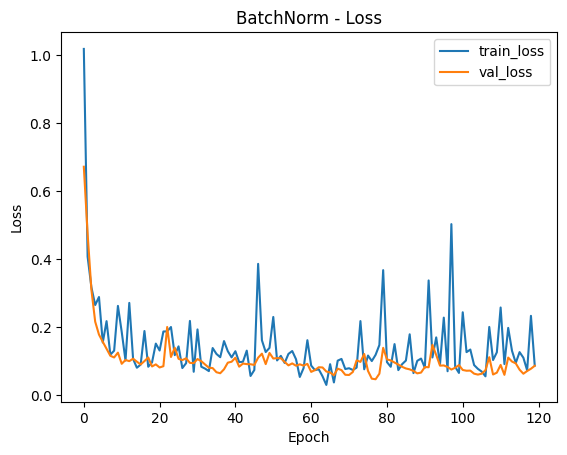

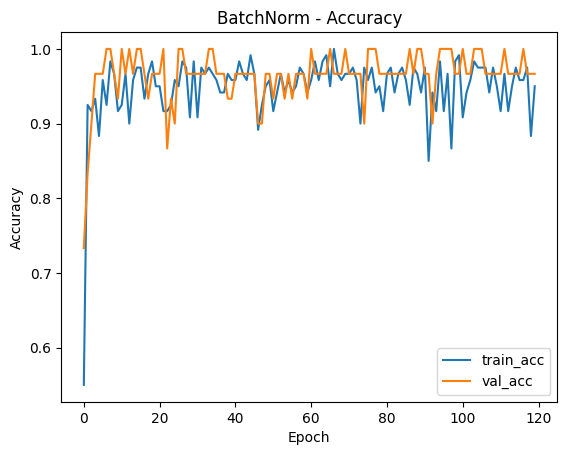

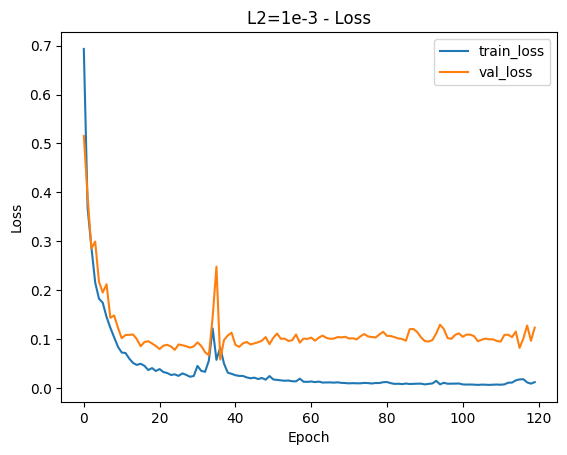

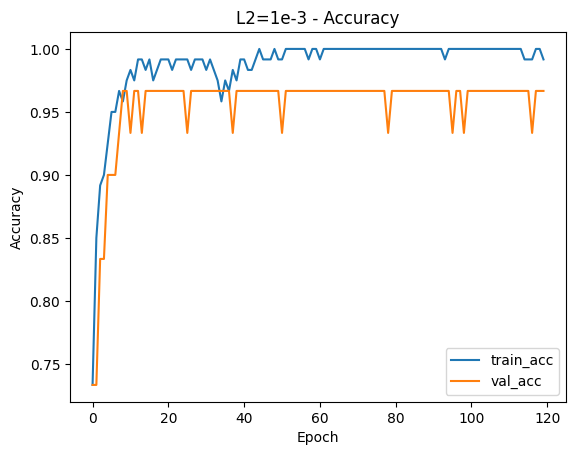

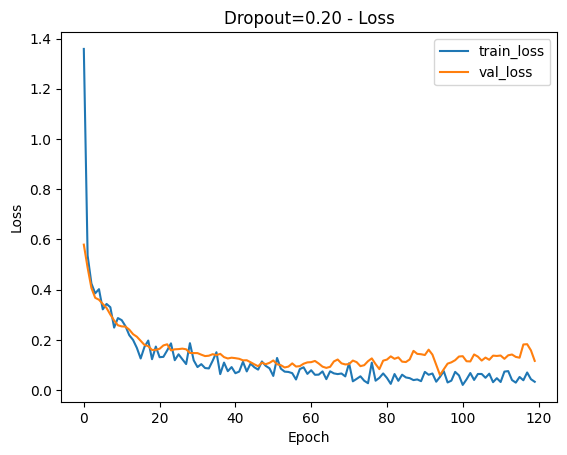

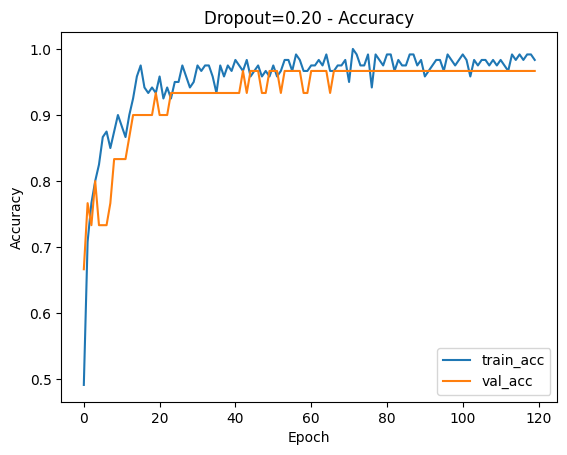

In [13]:
import time, math, copy, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import inspect
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)
torch.manual_seed(42)

try:
    MLPClassifier
    MLPClass = MLPClassifier
    HAS_OWN = True
except NameError:
    HAS_OWN = False
    class MLPClass(nn.Module):
        def __init__(self, in_features, hidden_sizes=(32,16), out_features=3,
                     dropout_p=0.0, use_batchnorm=False, activation="relu"):
            super().__init__()
            act = {"relu": nn.ReLU, "tanh": nn.Tanh, "gelu": nn.GELU}.get(activation, nn.ReLU)
            layers = []
            prev = in_features
            self.use_bn = use_batchnorm
            self.bns = nn.ModuleList()
            for h in hidden_sizes:
                layers.append(nn.Linear(prev, h))
                if use_batchnorm:
                    self.bns.append(nn.BatchNorm1d(h))
                layers.append(act())
                if dropout_p and dropout_p > 0:
                    layers.append(nn.Dropout(p=dropout_p))
                prev = h
            self.feats = nn.Sequential(*layers)
            self.head = nn.Linear(prev, out_features)

            # init
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    if m.bias is not None:
                        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                        nn.init.uniform_(m.bias, -bound, bound)

        def forward(self, x):
            # si hay BN se aplicó en la pila; en este fallback BN está dentro de self.bns si use_batchnorm=True
            if self.use_bn:
                # reconstruir secuencial aplicando BN en cada bloque linear
                pass
            z = self.feats(x)
            return self.head(z)

# ---------- Utilidades ----------
def accuracy_from_logits(logits, y_true):
    y_pred = logits.argmax(1)
    return (y_pred == y_true).float().mean().item()

@torch.no_grad()
def f1_macro_from_logits(logits, y_true):
    y_pred = logits.argmax(1).cpu().numpy()
    y_true = y_true.cpu().numpy()
    return f1_score(y_true, y_pred, average="macro")

def make_loader(X, y, mode, batch_size=16, shuffle=True):
    ds = TensorDataset(X, y)
    if mode == "sgd":      # stochastic: bs=1
        bs = 1
    elif mode == "batch":  # batch GD: todo en conjunto
        bs = len(ds)
    else:                  # mini
        bs = batch_size
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

def build_optimizer(params, name, lr, weight_decay):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(params, lr=lr, weight_decay=weight_decay)
    elif name == "adam":
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"opt no soportado: {name}")

def l1_penalty(model):
    l1 = 0.0
    for p in model.parameters():
        if p.requires_grad:
            l1 = l1 + p.abs().sum()
    return l1

# ---------- Adaptador de argumentos para MLPClassifier ----------
def _instantiate_user_mlp(
    in_features, out_features, hidden_sizes, dropout_p, use_batchnorm, activation
):
    """
    Intenta instanciar tu MLPClassifier mapeando nombres de argumentos comunes.
    Si tu clase no soporta alguno (p.ej. dropout), simplemente no lo pasa.
    """
    sig = inspect.signature(MLPClass)
    params = sig.parameters
    kw = {}

    def put(value, *candidates):
        for name in candidates:
            if name in params:
                kw[name] = value
                return True
        return False

    # Mapear nombres típicos
    put(in_features,   "in_features", "input_dim", "input_size", "n_features")
    put(out_features,  "out_features","output_dim","num_classes","n_classes")
    put(hidden_sizes,  "hidden_sizes","hidden_dims","hidden_layers","layers")
    put(dropout_p,     "dropout_p", "dropout", "p_drop")
    put(use_batchnorm, "use_batchnorm","batchnorm","use_bn")
    put(activation,    "activation","activation_fn","act")

    # Intento 1: kwargs mapeados
    try:
        return MLPClass(**kw)
    except TypeError:
        pass

    # Intento 2: posicionales comunes (in, hidden, out)
    try:
        return MLPClass(in_features, hidden_sizes, out_features)
    except TypeError:
        pass

    # Intento 3: posicionales (in, out)
    try:
        return MLPClass(in_features, out_features)
    except TypeError as e:
        raise TypeError(
            f"No pude instanciar tu MLPClassifier con kwargs {kw} ni con formas posicionales típicas; "
            f"revisa la __init__ de tu clase. Error original: {e}"
        )

def build_model_with_auto_args(config):
    return _instantiate_user_mlp(
        in_features=X_train.shape[1],
        out_features=len(torch.unique(y_train)),
        hidden_sizes=config.get("hidden_sizes", (32,16)),
        dropout_p=config.get("dropout_p", 0.0),
        use_batchnorm=config.get("use_batchnorm", False),
        activation=config.get("activation", "relu"),
    )

def train_one_config(config, epochs=120, device="cpu", verbose=False):
    """
    config:
      {
        'hidden_sizes': (32,16),
        'dropout_p': 0.0,
        'use_batchnorm': False,
        'optimizer': 'adam'|'sgd',
        'batch_mode': 'mini'|'sgd'|'batch',
        'batch_size': 16,
        'lr': 1e-2,
        'weight_decay': 0.0,  # L2
        'lambda_l1': 0.0,     # L1
        'loss': 'cross_entropy'
      }
    """
    if HAS_OWN:
        model = build_model_with_auto_args(config).to(device)
    else:
        model = MLPClass(
            in_features=X_train.shape[1],
            hidden_sizes=config.get("hidden_sizes", (32,16)),
            out_features=len(torch.unique(y_train)),
            dropout_p=config.get("dropout_p", 0.0),
            use_batchnorm=config.get("use_batchnorm", False),
            activation=config.get("activation", "relu"),
        ).to(device)

    opt = build_optimizer(model.parameters(),
                          name=config.get("optimizer", "adam"),
                          lr=config.get("lr", 1e-2),
                          weight_decay=config.get("weight_decay", 0.0))

    loss_name = config.get("loss", "cross_entropy").lower()
    if loss_name == "cross_entropy":
        def compute_loss(logits, y): return F.cross_entropy(logits, y)
    else:
        raise ValueError("Para Task 6 fijamos loss='cross_entropy' (simple y comparable).")

    train_loader = make_loader(X_train, y_train, mode=config.get("batch_mode","mini"),
                               batch_size=config.get("batch_size",16), shuffle=True)
    val_loader   = make_loader(X_val,   y_val,   mode="batch", batch_size=len(y_val), shuffle=False)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    t0 = time.perf_counter()
    for epoch in range(epochs):
        model.train()
        agg_loss, agg_acc, n = 0.0, 0.0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = compute_loss(logits, yb)

            lam_l1 = config.get("lambda_l1", 0.0)
            if lam_l1 and lam_l1 > 0:
                loss = loss + lam_l1 * l1_penalty(model)

            opt.zero_grad()
            loss.backward()
            opt.step()

            agg_loss += loss.item() * yb.size(0)
            agg_acc  += (logits.argmax(1) == yb).float().sum().item()
            n += yb.size(0)

        train_loss = agg_loss / n
        train_acc  = agg_acc / n

        # evaluación
        model.eval()
        with torch.no_grad():
            xb_val, yb_val = next(iter(val_loader))
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            logits_val = model(xb_val)
            val_loss = compute_loss(logits_val, yb_val).item()
            val_acc  = accuracy_from_logits(logits_val, yb_val)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if verbose and (epoch+1) % 40 == 0:
            print(f"ep {epoch+1:03d} | tr_loss {train_loss:.4f} val_loss {val_loss:.4f} | tr_acc {train_acc:.3f} val_acc {val_acc:.3f}")

    total_time_sec = time.perf_counter() - t0

    # métricas finales
    model.eval()
    with torch.no_grad():
        logits_val = model(X_val.to(device))
        final_f1 = f1_macro_from_logits(logits_val, y_val.to(device))

    return {
        "config": copy.deepcopy(config),
        "history": history,
        "final": {
            "train_loss": history["train_loss"][-1],
            "val_loss":   history["val_loss"][-1],
            "train_acc":  history["train_acc"][-1],
            "val_acc":    history["val_acc"][-1],
            "f1_macro":   float(final_f1),
            "total_time_sec": float(total_time_sec),
        },
        "model": model
    }

# ---------- Definir ≥9 combinaciones ----------
BASE = {
    "hidden_sizes": (32,16),
    "dropout_p": 0.0,
    "use_batchnorm": False,
    "optimizer": "adam",
    "batch_mode": "mini",
    "batch_size": 16,
    "lr": 1e-2,
    "weight_decay": 0.0,
    "lambda_l1": 0.0,
    "loss": "cross_entropy",
    "activation": "relu",
}

COMBINATIONS = [
    {**BASE, "dropout_p": 0.0, "use_batchnorm": False, "weight_decay": 0.0,   "lambda_l1": 0.0,     "name": "NoReg"},
    {**BASE, "weight_decay": 1e-4,                 "name": "L2=1e-4"},
    {**BASE, "weight_decay": 5e-4,                 "name": "L2=5e-4"},
    {**BASE, "weight_decay": 1e-3,                 "name": "L2=1e-3"},
    {**BASE, "lambda_l1": 1e-5,                    "name": "L1=1e-5"},
    {**BASE, "lambda_l1": 1e-4,                    "name": "L1=1e-4"},
    {**BASE, "dropout_p": 0.20,                    "name": "Dropout=0.20"},
    {**BASE, "dropout_p": 0.50,                    "name": "Dropout=0.50"},
    {**BASE, "use_batchnorm": True,                "name": "BatchNorm"},
]

# ---------- Ejecutar, recolectar historia y métricas ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
all_runs = []
for cfg in COMBINATIONS:
    res = train_one_config(cfg, epochs=120, device=device, verbose=False)
    all_runs.append(res)

# ---------- Tabla de resumen ----------
import pandas as pd
rows = []
for r in all_runs:
    c = r["config"]
    f = r["final"]
    rows.append({
        "name": c.get("name",""),
        "optimizer": c["optimizer"],
        "batch_mode": c["batch_mode"],
        "lr": c["lr"],
        "L2_weight_decay": c["weight_decay"],
        "L1_lambda": c["lambda_l1"],
        "dropout_p": c["dropout_p"],
        "batchnorm": c["use_batchnorm"],
        "epochs": len(r["history"]["train_loss"]),
        "train_loss": f["train_loss"],
        "val_loss": f["val_loss"],
        "train_acc": f["train_acc"],
        "val_acc": f["val_acc"],
        "f1_macro": f["f1_macro"],
        "time_sec": f["total_time_sec"],
    })
results_df = pd.DataFrame(rows).sort_values(["val_acc","f1_macro"], ascending=False).reset_index(drop=True)
display(results_df)

# ---------- Curvas: graficar Top-3 por val_acc ----------
TOPK = 3
top_idx = results_df.head(TOPK).index.tolist()
name_to_run = { r["config"].get("name",""): r for r in all_runs }
top_runs = []
for i in range(TOPK):
    nm = results_df.loc[i, "name"]
    top_runs.append(name_to_run[nm])

def plot_curves(history, title=""):
    plt.figure()
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'],   label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(title + " - Loss"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'],   label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(title + " - Accuracy"); plt.legend(); plt.show()

for r in top_runs:
    title = r["config"].get("name","(sin nombre)")
    plot_curves(r["history"], title=title)
